## Advanced Line Finding

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# Dependencies

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

## Camera Calibration

In [2]:
def camCalibrate(imagesPath, chessInnerCorner_x, chessInnerCorner_y, save = False, plot = True):
    """
    Calibrate the camera used to take pictures of the chessboard appended on the wall. All the images must be of the same size
    imagesPath:          path of the images containing chessboard picture
    chessInnerCorner_h:   number of inner corners on x axis (horizontal)
    chessInnerCorner_y:    number of inner corners on y axis (vertical)
    """
    totCorners = chessInnerCorner_x*chessInnerCorner_y
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) to store the chessboard square coordinate
    objp = np.zeros((totCorners,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessInnerCorner_x, 0:chessInnerCorner_y].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    if plot == True:
        nimg = len(images)
        nr = int(nimg/4)
        fig, axs = plt.subplots(nr,4, figsize=(15, 10))
        axs = axs.ravel() 
    else:
        fig = [];


    for idx, fname in enumerate(imagesPath):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessInnerCorner_x, chessInnerCorner_y), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
        if plot == True:
            img = cv2.drawChessboardCorners(img, (chessInnerCorner_x, chessInnerCorner_y), corners, ret)
            axs[idx].imshow(img)
                

    # Get the size of on image
    timg = cv2.imread(imagesPath[0])
    imgSize = (timg.shape[1], timg.shape[0])
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)
    
    if (save ==True):
        calibrationData = {}
        calibrationData["mtx"] = mtx
        calibrationData["dist"] = dist
        
        
    return mtx, dist, fig

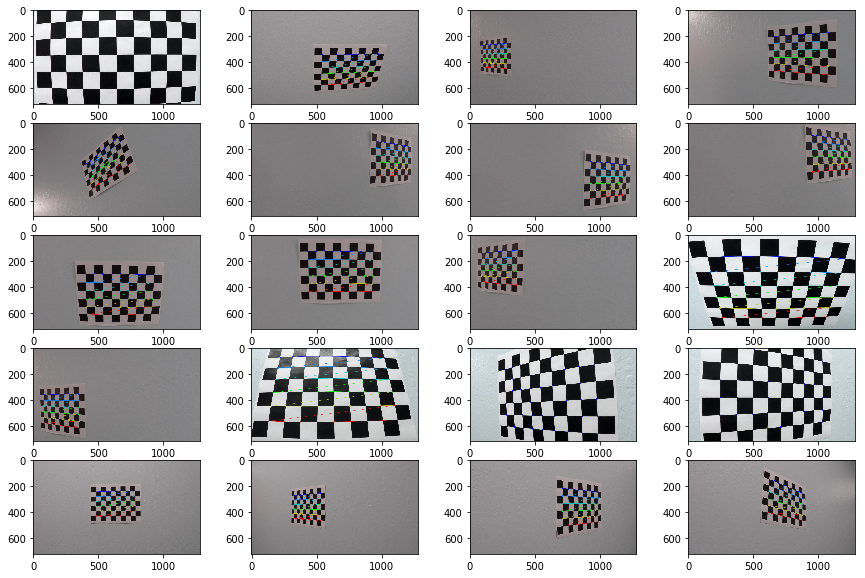

In [3]:
# List of images to be used for caamera calibration (chess board images)
images = glob.glob('resource/camera_cal/calibration*.jpg')
mtx1, dist1, fig1 = camCalibrate(images, chessInnerCorner_x=9, chessInnerCorner_y=6)

fig1.savefig("example/ChessboardCornersCalibration.png", bbox_inches='tight')

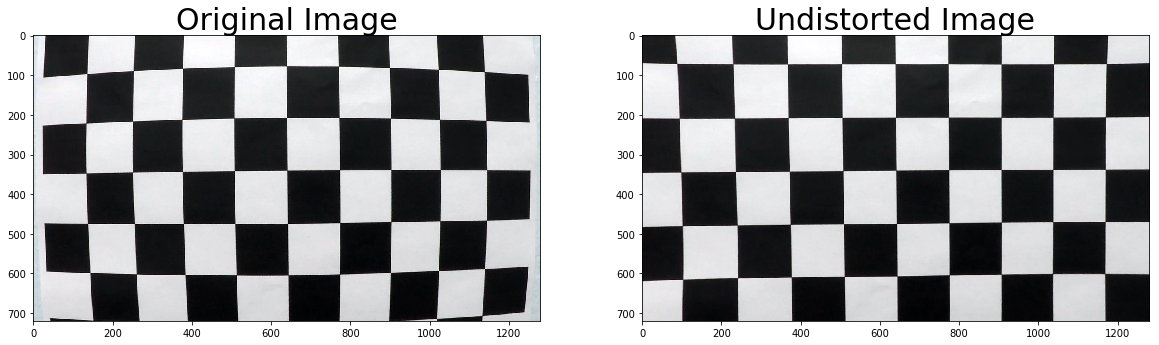

In [4]:
# Plot undistortion calibration on test image

## visualize undistortion on image
img = cv2.imread(images[0])
correctImage = cv2.undistort(img, mtx1, dist1, None, mtx1)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(correctImage)
ax2.set_title('Undistorted Image', fontsize=30)

# fig2.savefig("example/UndistortedChessboard.png", bbox_inches='tight')

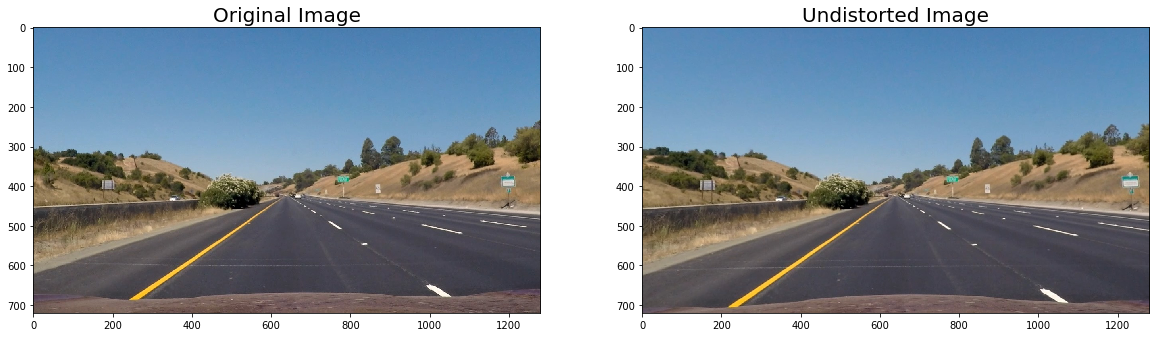

In [6]:
# Visualize undistortion on road image
testImg = cv2.imread("resource/test_images/straight_lines1.jpg")
testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
correctImg = cv2.undistort(testImg, mtx1, dist1, None, mtx1)

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testImg)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(correctImg)
ax2.set_title('Undistorted Image', fontsize=20)

# fig3.savefig("example/UndistortedLane.png", bbox_inches='tight')

## Perspective Transform

In [7]:

def perspectiveTransform(img):
    """
    Transform the perspective of the image captured by camera mounted on the car
    Note: it may be neccessary to cange the source and destination coordinates
    
    warped:  image transformed from source to destination
    unwarp:  image transformed from destination to source
    """

    imgSize = (img.shape[1], img.shape[0])
    
    # Source and destination points for transform. Points coordinates approx
    # [lowLeft, lowright, upLeft, upRight]
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])

    m = cv2.getPerspectiveTransform(src, dst)
    mInv = cv2.getPerspectiveTransform(dst, src)

    warp = cv2.warpPerspective(img, m, imgSize, flags=cv2.INTER_LINEAR)
    unwarp = cv2.warpPerspective(warp, mInv, (warp.shape[1], warp.shape[0]), flags=cv2.INTER_LINEAR)  

    return m, mInv, warp, unwarp


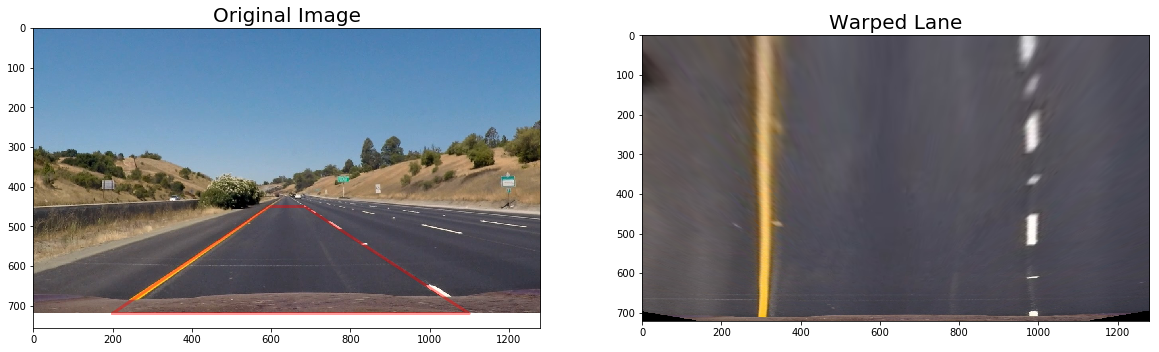

In [8]:
# testImg = cv2.imread("resource/test_images/straight_lines1.jpg")
# testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)

m, mInv, warp, unwarp = perspectiveTransform(testImg)

# Visualize warp
# h, w = testImg.shape[:2]
src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testImg)
ax2.imshow(warp)
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_title('Original Image', fontsize=20)
ax2.set_title('Warped Lane', fontsize=20)

# fig4.savefig("example/WarpedLane.png", bbox_inches='tight')

## Colorspace

In [9]:
def absSobelThresh(img, orient='x', thresh_min=20, thresh_max=100):
    """
    Identify pixels of an image where the gradient falls within a specified threshold range
    arguments:  img, 
                gradient orientation: "x", or "y:
                and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        absSobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        absSobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    # Rescale back to 8 bit integer
    scaledSobel = np.uint8(255*absSobel/np.max(absSobel))

    # Create a copy and apply the threshold
    binaryOutput = np.zeros_like(scaledSobel)
    binaryOutput[(scaledSobel >= thresh_min) & (scaledSobel <= thresh_max)] = 1

    # Return the result
    return binaryOutput

def magThresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the gradient magnitude
    gradMag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scaleFactor = np.max(gradMag)/255
    gradMag = (gradMag/scaleFactor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binaryOutput = np.zeros_like(gradMag)
    binaryOutput[(gradMag >= mag_thresh[0]) & (gradMag <= mag_thresh[1])] = 1

    # Return the binary image
    return binaryOutput


def dirThresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binaryOutput =  np.zeros_like(absgraddir)
    binaryOutput[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binaryOutput


def hls_thresh(img, thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binaryOutput = np.zeros_like(s_channel)
    binaryOutput[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binaryOutput




In [10]:
def combinedThresh(img):
    """
    Combined gradient filter, setting thresholds for absolute gradient, magnitude of the gradient
    direction of gradient and hls
    """
    absGr = absSobelThresh(img, orient='x', thresh_min=50, thresh_max=255)
    magGr = magThresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dirGr = dirThresh(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hlsGr = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dirGr)
    combined[(absGr == 1 | ((magGr == 1) & (dirGr == 1))) | hlsGr == 1] = 1

    return combined, absGr, magGr, dirGr, hlsGr 

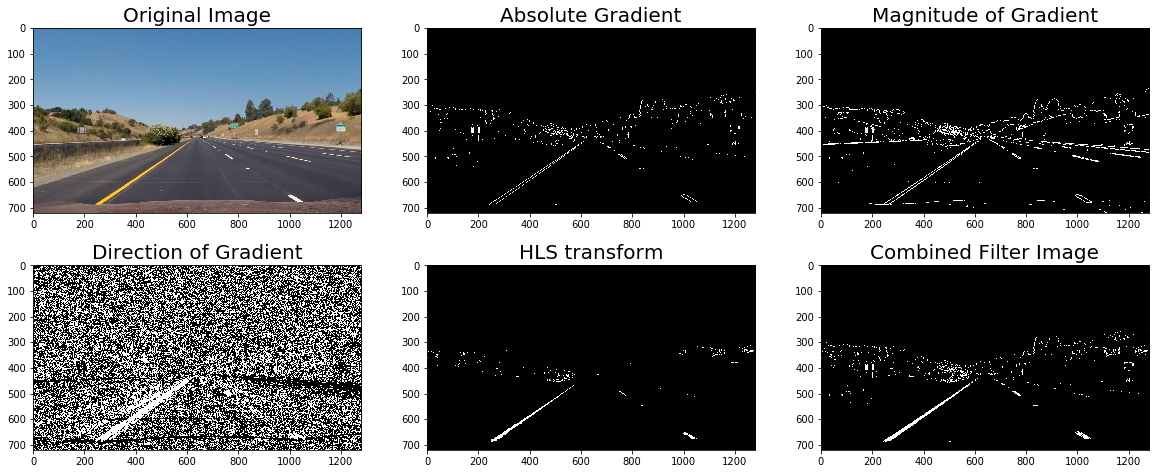

In [11]:
# Thresholded binary image
combImg, absImg, magImg, dirImg, hlsImg = combinedThresh(testImg)

#plt.imshow(img, cmap='gray', vmin=0, vmax=1)

fig5, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize=(20,8))
ax1.imshow(testImg)
ax2.imshow(absImg, cmap='gray')
ax3.imshow(magImg, cmap='gray')
ax4.imshow(dirImg, cmap='gray')
ax5.imshow(hlsImg, cmap='gray')
ax6.imshow(combImg, cmap='gray')
ax1.set_title('Original Image', fontsize=20)
ax2.set_title('Absolute Gradient', fontsize=20)
ax3.set_title('Magnitude of Gradient', fontsize=20)
ax4.set_title('Direction of Gradient', fontsize=20)
ax5.set_title('HLS transform', fontsize=20)
ax6.set_title('Combined Filter Image', fontsize=20)

#fig5.savefig("example/ColorGradientFilter.png", bbox_inches='tight')

## Determine Lane Line and Lane Curvature

In [26]:

def lineFit(binary_warped):
    """
    Find and fit lane lines to a warped image
    binary_warped:     binary image that has been previously warped for lane line
    
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    outImg = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype('uint8')

    # Find the peak of the left and right halves of the histogram. These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[100:midpoint]) + 100
    rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100  # Set the width of the windows +/- margin  
    minpix = 50   # Set minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    rectangle = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(outImg,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(outImg,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        rectangle.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Return a dict of relevant variables
    ret = {}
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    ret['nonzerox'] = nonzerox
    ret['nonzeroy'] = nonzeroy
    ret['outImg'] = outImg
    ret['left_lane_inds'] = left_lane_inds
    ret['right_lane_inds'] = right_lane_inds
    ret['rectangle'] = rectangle
    ret['histogram'] = histogram

    return ret

In [63]:
def visualizeFit(tImg, ret):
    """
    tImg:  binary warped image of lane (bird eyes view)
    ret:   dictionary containing left_fit, right_fit,...
    """
    
    # Grab variables from ret dictionary
    leftFit = ret['left_fit']
    rightFit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    leftLaneInds = ret['left_lane_inds']
    rightLaneInds = ret['right_lane_inds']
    rectangle = ret['rectangle']
    
    
    h = tImg.shape[0]
    leftFit_x_int = leftFit[0]*h**2 + leftFit[1]*h + leftFit[2]
    rightFit_x_int = rightFit[0]*h**2 + rightFit[1]*h + rightFit[2]
    #print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

    # Create an output image to draw on and  visualize the result
    outImg2 = np.uint8(np.dstack((tImg, tImg, tImg))*255)

    # Generate x and y values for plotting
    ploty = np.linspace(0, tImg.shape[0]-1, tImg.shape[0] )
    leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]

    for r in rectangle: 
        cv2.rectangle(outImg2,(r[2], r[0]),(r[3],r[1]),(0,255,0), 2) 
        cv2.rectangle(outImg2,(r[4], r[0]),(r[5],r[1]),(0,255,0), 2)

    # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = tImg.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    outImg2[nonzeroy[leftLaneInds], nonzerox[leftLaneInds]] = [255, 0, 0]
    outImg2[nonzeroy[rightLaneInds], nonzerox[rightLaneInds]] = [100, 200, 255]
    

    pret =  plt.imshow(outImg2)
    plt.plot(leftFitx, ploty, color='orange', linewidth = 4)
    plt.plot(rightFitx, ploty, color='orange', linewidth =4)
    plt.title('Line Fit', fontsize=20)

    return pret


In [64]:
def continueLineFit(binary_warped, left_fit, right_fit, rectangle):
    """
    Given a previously fit line, quickly try to find the line based on previous lines
    binary_warped:         new binary image, previously warped to detect lanes
    left_fit, right_fit:   fitted line from previous warped image
    """
    # Assume you now have a new warped binary image from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If we don't find enough relevant points, return all None (this means error)
    min_inds = 10
    if lefty.shape[0] < min_inds or righty.shape[0] < min_inds:
        return None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Return a dict of relevant variables
    ret = {}
    ret['left_fit'] = left_fit
    ret['right_fit'] = right_fit
    ret['nonzerox'] = nonzerox
    ret['nonzeroy'] = nonzeroy
    ret['left_lane_inds'] = left_lane_inds
    ret['right_lane_inds'] = right_lane_inds
    ret['rectangle'] = rectangle

    return ret

In [23]:
##  Example on 2 images 
testImg1 = cv2.imread("resource/test_images/test1.jpg")
testImg2 = cv2.imread("resource/test_images/straight_lines2.jpg")
testImg1 = cv2.cvtColor(testImg1, cv2.COLOR_BGR2RGB)
testImg2 = cv2.cvtColor(testImg2, cv2.COLOR_BGR2RGB)

# Undistort
tImg1 = cv2.undistort(testImg1, mtx1, dist1, None, mtx1)
tImg2 = cv2.undistort(testImg2, mtx1, dist1, None, mtx1)

# Gradient
tImg1, absImg1, magImg1, dirImg1, hlsImg1 = combinedThresh(tImg1)
tImg2, absImg2, magImg2, dirImg2, hlsImg2 = combinedThresh(tImg2)

# Perspective (warping)
m1, mInv1, tImg1, unwarp1 = perspectiveTransform(tImg1)
m2, mInv2, tImg2, unwarp2 = perspectiveTransform(tImg2)


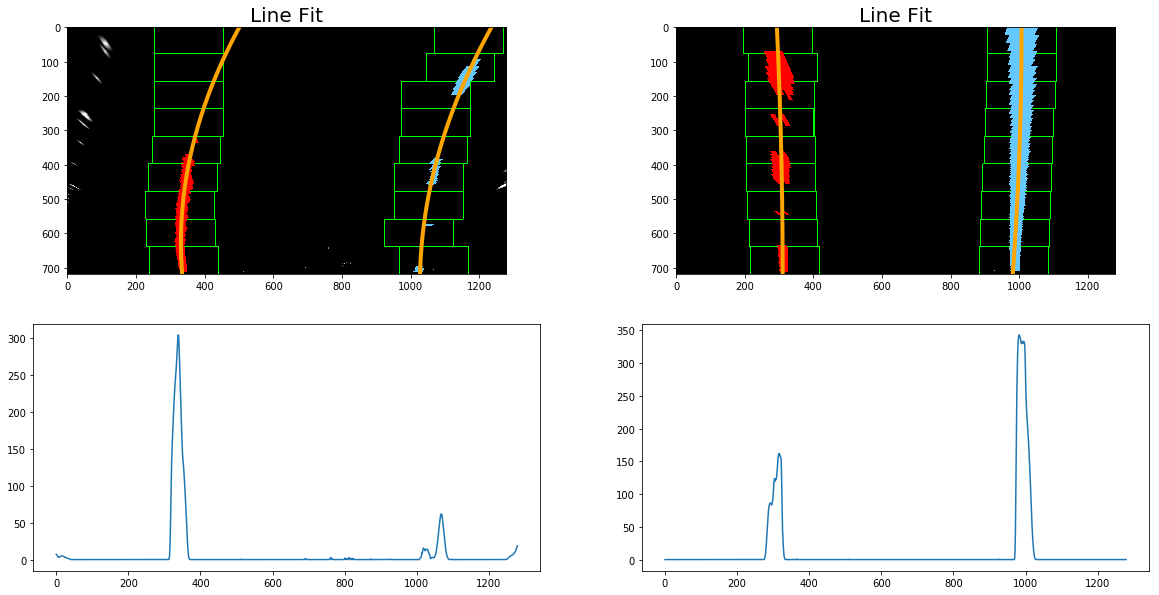

In [65]:
# Polynomial fit
ret1 = lineFit(tImg1)
ret2 = lineFit(tImg2)

# ret2b = continueLineFit(tImg1, ret1['left_fit'], ret1['right_fit'], ret1['rectangle'])
# visualizeFit(tImg2, ret2b)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
visualizeFit(tImg1, ret1)
plt.subplot(2,2,2)
visualizeFit(tImg2, ret2)
plt.subplot(2,2,3)
plt.plot(ret1['histogram'])
plt.subplot(2,2,4)
plt.plot(ret2['histogram'])
    

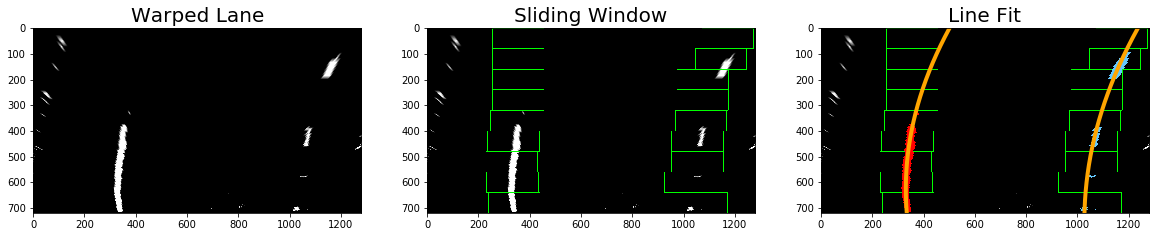

In [66]:
fig6, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
# plt.plot(leftFitx, ploty, color='orange', linewidth = 4)
# plt.plot(rightFitx, ploty, color='orange', linewidth =4)
ax1.imshow(tImg1, cmap='gray')
ax2.imshow(ret1["outImg"], cmap='gray')
ax3 = visualizeFit(tImg1, ret1)
# ax3.plot(leftFitx, ploty, color='orange', linewidth = 4)
# ax3.plot(rightFitx, ploty, color='orange', linewidth =4)
ax1.set_title('Warped Lane', fontsize=20)
ax2.set_title('Sliding Window', fontsize=20)

# ax4.plot(hist)
# ax4.set_title('Histogram for Lane Lines', fontsize=20)

fig6.savefig("example/LanesLineFit2.png", bbox_inches='tight')

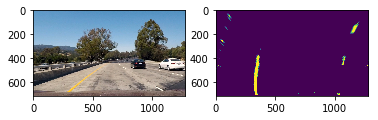

In [47]:
plt.subplot(1,2,1)
plt.imshow(testImg1)
plt.subplot(1,2,2)
plt.imshow(tImg1)

In [51]:
## Calculate curvature
def curveRadius_CenterDist(binImg, ret):
    """
    Calculate radius of curvature in meters
    Define y-value where we want radius of curvature. I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    Formula for left and right curvature radius:
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    """
    
    # Grab variables from ret dictionary
#     leftFit = ret['left_fit']
#     rightFit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    leftLaneInds = ret['left_lane_inds']
    rightLaneInds = ret['right_lane_inds']
    
#     leftCurveRad, rightCurveRad, centerDist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = binImg.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    # y_eval = 719  # correspond to the lowest y coordinate of a 720p image

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = binImg.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[leftLaneInds]
    lefty = nonzeroy[leftLaneInds] 
    rightx = nonzerox[rightLaneInds]
    righty = nonzeroy[rightLaneInds]

    # Fit new polynomials to x,y under real meters measure
    leftFit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    rightFit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new curvature radius in meters
    leftCurveRad = ((1 + (2*leftFit[0]*y_eval*ym_per_pix + leftFit[1])**2)**1.5) / np.absolute(2*leftFit[0])
    rightCurveRad = ((1 + (2*rightFit[0]*y_eval*ym_per_pix + rightFit[1])**2)**1.5) / np.absolute(2*rightFit[0])
    
    # Distance from center is image x midpoint - mean of leftFit and rightFit intercepts 
    if rightFit is not None and leftFit is not None:
        tposition = binImg.shape[1]/2  # horizontal midpoint 
        lFitx = leftFit[0]*h**2 + leftFit[1]*h + leftFit[2]
        rFitx = rightFit[0]*h**2 + rightFit[1]*h + rightFit[2]
        laneCenter = (rFitx + lFitx) /2
        centerDist = (tposition - laneCenter) * xm_per_pix
             
    return leftCurveRad, rightCurveRad, centerDist

In [54]:

def visualizeLaneOverlay(origImg, warpImg, leftFit, rightFit, mInv, lRad, rRad, cDist):
    """
    Final lane line prediction visualized and overlayed on top of original image
    origImage:     original image of the lane (h0, w0, 3)
    warpImage:     binary warped image (h,w)
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, origImg.shape[0]-1, origImg.shape[0])
    
    leftFit2 = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFit2 = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]

    h,w = warpImg.shape
    # Create an image to draw the lines on
    warpZero = np.zeros_like(warpImg).astype(np.uint8)
    colorWarp = np.dstack((warpZero, warpZero, warpZero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftFit2, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightFit2, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
    cv2.polylines(colorWarp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(colorWarp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newWarp = cv2.warpPerspective(colorWarp, mInv, (w, h))
    
    # Combine the result with the original image
    result = cv2.addWeighted(origImg, 1, newWarp, 0.3, 0)

    # Annotate lane curvature values and vehicle offset from center
    avgRadCurve = (lRad + rRad)/2
    labRad = 'Radius of curvature:       %.1f m' % avgRadCurve
    result = cv2.putText(result, labRad, (20,50), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    labDist = 'Distance from lane center: %.1f m' % cDist
    result = cv2.putText(result, labDist, (20,100), 0, 1, (0,0,0), 2, cv2.LINE_AA)    

    return result


In [55]:
# Test images 
##  Example on 2 images 
# testImg1 = cv2.imread("resource/test_images/test1.jpg")
# testImg2 = cv2.imread("resource/test_images/straight_lines2.jpg")
# testImg1 = cv2.cvtColor(testImg1, cv2.COLOR_BGR2RGB)
# testImg2 = cv2.cvtColor(testImg2, cv2.COLOR_BGR2RGB)

# # Undistort
# tImg1 = cv2.undistort(testImg1, mtx1, dist1, None, mtx1)
# tImg2 = cv2.undistort(testImg2, mtx1, dist1, None, mtx1)

# # Gradient
# tImg1, absImg1, magImg1, dirImg1, hlsImg1 = combinedThresh(tImg1)
# tImg2, absImg2, magImg2, dirImg2, hlsImg2 = combinedThresh(tImg2)

# # Perspective (warping)
# m1, mInv1, tImg1, unwarp1 = perspectiveTransform(tImg1)
# m2, mInv2, tImg2, unwarp2 = perspectiveTransform(tImg2)

# # Polynomial fit
# ret1 = lineFit(tImg1)
# ret2 = lineFit(tImg2)

# leftFit = ret['left_fit']
# rightFit = ret['right_fit']
# nonzerox = ret['nonzerox']
# nonzeroy = ret['nonzeroy']
# leftLaneInds = ret['left_lane_inds']
# rightLaneInds = ret['right_lane_inds']

lRad1, rRad1, cDist1 = curveRadius_CenterDist(tImg1, ret1)
lRad2, rRad2, cDist2 = curveRadius_CenterDist(tImg2, ret2)

fImg1 = visualizeLaneOverlay(testImg1, tImg1, ret1['left_fit'], ret1['right_fit'], mInv1, lRad1, rRad1, cDist1)
fImg2 = visualizeLaneOverlay(testImg2, tImg2, ret2['left_fit'], ret2['right_fit'], mInv2, lRad2, rRad2, cDist2)

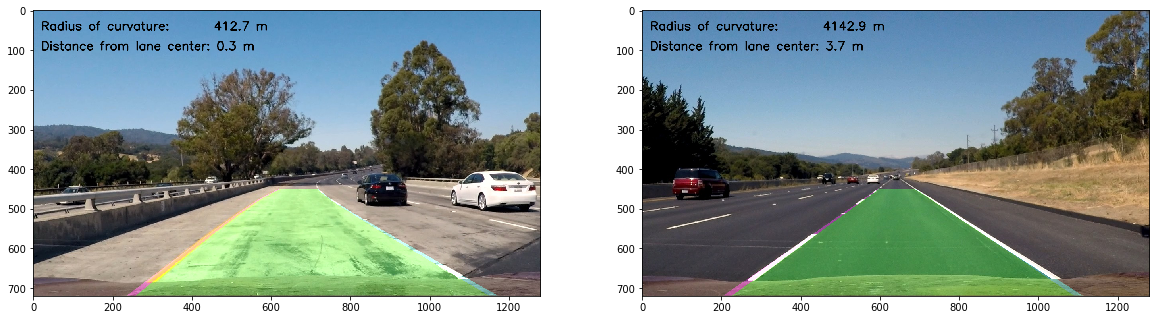

In [57]:
fig7 = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(tImg1)
plt.subplot(1,2,2)
plt.imshow(fImg2)

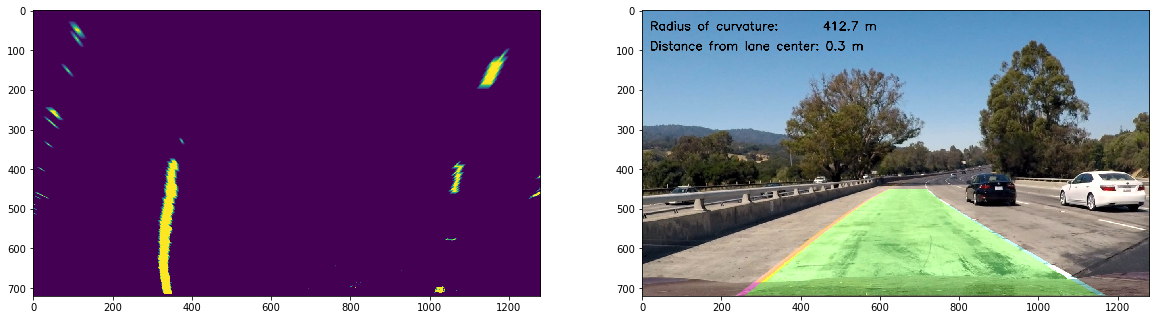

In [59]:
fig7a = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(tImg1)
plt.subplot(1,2,2)
plt.imshow(fImg1)

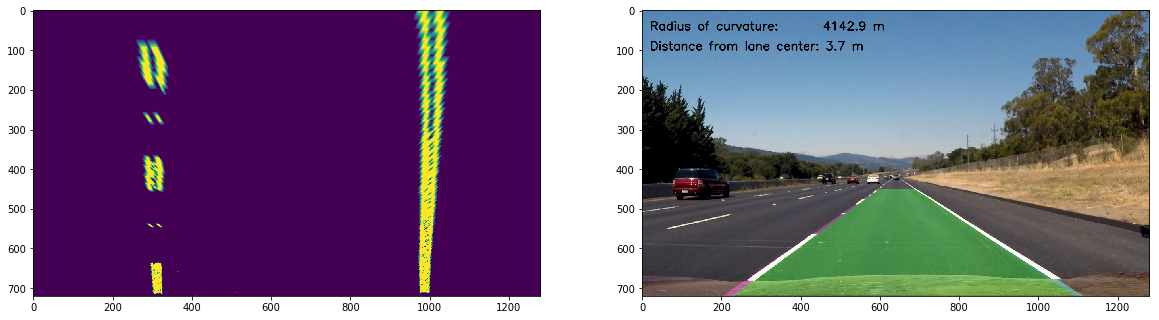

In [60]:
fig7b = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(tImg2)
plt.subplot(1,2,2)
plt.imshow(fImg2)

In [67]:
def pipeline(imgPathm, mtx, dist):
    """
    Pipeline for advanced lane detection. Import images using openCV
    imgPath:    path of the image
    mtx:        camera calibration for distortion
    dist:       camera calibration for distortion
    
    """
    img1 = cv2.imread(imgPath)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    # Undistort
    undistImg = cv2.undistort(img1, mtx, dist, None, mtx)

    # Gradient filter
    comboGr, absGr, magGr, dirGr, hlsGr = combinedThresh(undistImg)

    # Perspective (warping)
    m, mInv, warpImg, unwarpImg = perspectiveTransform(comboGr)
    
    # Polynomial fit
    ret = lineFit(warpImg)
    
    # Visualize lane fit plot
    fitPlot = visualizeFit(warpImg, ret)

    # Calculate curvature radius and distance from center
    lRad, rRad, cDist = curveRadius_CenterDist(warpImg, ret)

    fImg = visualizeLaneOverlay(undistImg, warpImg, ret['left_fit'], ret['right_fit'], mInv, lRad, rRad, cDist)
    
    return ret, fitPlot, fImg

    

In [68]:
# List test images 
timages = glob.glob('resource/test_images/*.jpg')
# Calibration result are alredy in memory as mtx1, dist1. Alternatively import calibration Data from 
with open("resource/calibration.p", mode='rb') as f:
    calibrationData = pickle.load(f)


In [69]:
calibrationData

{'dist': array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

In [ ]:
# After you've tuned your pipeline on test images, you'll run on a video stream, just like in the first project. 
# In this case, however, you're going to keep track of things like where your last several detections of the lane lines 
# were and what the curvature was, so you can properly treat new detections. To do this, it's useful to define a Line() class 
# to keep track of all the interesting parameters you measure from frame to frame. Here's an example:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
	def __init__(self, n):
		"""
		n is the window size of the moving average
		"""
		self.n = n
		self.detected = False

		# Polynomial coefficients: x = A*y^2 + B*y + C
		# Each of A, B, C is a "list-queue" with max length n
		self.A = []
		self.B = []
		self.C = []
		# Average of above
		self.A_avg = 0.
		self.B_avg = 0.
		self.C_avg = 0.

	def get_fit(self):
		return (self.A_avg, self.B_avg, self.C_avg)

	def add_fit(self, fit_coeffs):
		"""
		Gets most recent line fit coefficients and updates internal smoothed coefficients
		fit_coeffs is a 3-element list of 2nd-order polynomial coefficients
		"""
		# Coefficient queue full?
		q_full = len(self.A) >= self.n

		# Append line fit coefficients
		self.A.append(fit_coeffs[0])
		self.B.append(fit_coeffs[1])
		self.C.append(fit_coeffs[2])

		# Pop from index 0 if full
		if q_full:
			_ = self.A.pop(0)
			_ = self.B.pop(0)
			_ = self.C.pop(0)

		# Simple average of line coefficients
		self.A_avg = np.mean(self.A)
		self.B_avg = np.mean(self.B)
		self.C_avg = np.mean(self.C)

		return (self.A_avg, self.B_avg, self.C_avg)


